# Tehran house price prediction(regresion)

## Initialization

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import  ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

import joblib

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Data Loading

In [ ]:
#set option
#pd.set_option('display.float_format', lambda x: '%.f' % x)

In [4]:
df = pd.read_csv('../input/house-price-tehran-iran/housePrice.csv')
df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


## Drop unnecessary columns

In [5]:
df = df.drop("Price(USD)", axis='columns')

## EDA


In [6]:
df.columns

Index(['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address', 'Price'], dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Area       3479 non-null   object 
 1   Room       3479 non-null   int64  
 2   Parking    3479 non-null   bool   
 3   Warehouse  3479 non-null   bool   
 4   Elevator   3479 non-null   bool   
 5   Address    3456 non-null   object 
 6   Price      3479 non-null   float64
dtypes: bool(3), float64(1), int64(1), object(2)
memory usage: 119.0+ KB


In [8]:
df['Area'] = df['Area'].apply(lambda x: re.sub(',', '', x))
df["Area"] = pd.to_numeric(df["Area"] , errors='coerce')

In [9]:
df.describe()

,Area,Room,Price
count,3.479000e+03,3479.000000,3.479000e+03
mean,8.744000e+06,2.079908,5.359023e+09
std,3.167266e+08,0.758275,8.099935e+09
min,3.000000e+01,0.000000,3.600000e+06
25%,6.900000e+01,2.000000,1.418250e+09
50%,9.000000e+01,2.000000,2.900000e+09
75%,1.200000e+02,2.000000,6.000000e+09
max,1.616000e+10,5.000000,9.240000e+10


In [10]:
# check for data types
print(df.dtypes)

Area           int64
Room           int64
Parking         bool
Warehouse       bool
Elevator        bool
Address       object
Price        float64
dtype: object


In [11]:
#check for null values
df.isnull().sum()

Area          0
Room          0
Parking       0
Warehouse     0
Elevator      0
Address      23
Price         0
dtype: int64

In [12]:
df['Parking'].value_counts(normalize=True)*100

True     84.794481
False    15.205519
Name: Parking, dtype: float64

In [13]:
pd.crosstab( df.Parking, df.Room )

Room,0,1,2,3,4,5
Parking,,,,,,
False,8,245,244,26,1,5
True,2,428,1717,706,69,28


In [14]:
pd.crosstab( df.Warehouse, df.Room )

Room,0,1,2,3,4,5
Warehouse,,,,,,
False,5,110,151,21,3,7
True,5,563,1810,711,67,26


In [15]:
len(df.Address.unique())

193

In [16]:
df.groupby( 'Room' )['Price'].mean()

Room
0    7.860500e+09
1    1.703751e+09
2    3.322727e+09
3    1.092580e+10
4    2.560033e+10
5    3.373439e+10
Name: Price, dtype: float64

In [17]:
room_parking_room_mean_df = df.groupby( ['Room','Parking'] )['Price'].mean().reset_index()
room_parking_room_mean_df

,Room,Parking,Price
0,0,False,9.769750e+09
1,0,True,2.235000e+08
2,1,False,1.135640e+09
3,1,True,2.028956e+09
4,2,False,1.501674e+09
5,2,True,3.581514e+09
6,3,False,5.107865e+09
7,3,True,1.114006e+10
8,4,False,6.200000e+09
9,4,True,2.588149e+10


## Visualization

<Figure size 800x500 with 0 Axes>

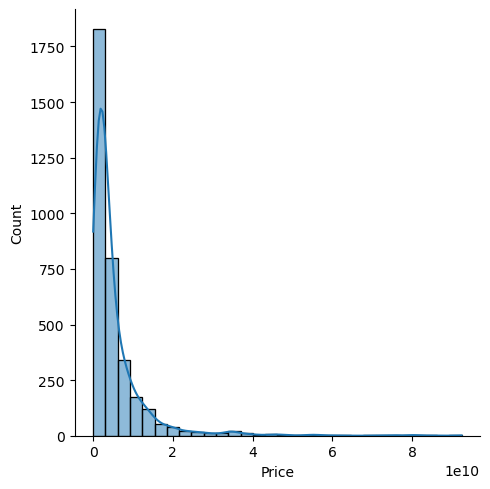

In [18]:
# Price distribution 
plt.figure(figsize=(8,5))
sns.displot(df['Price'] , bins=30 , kde=True )

<Axes: >

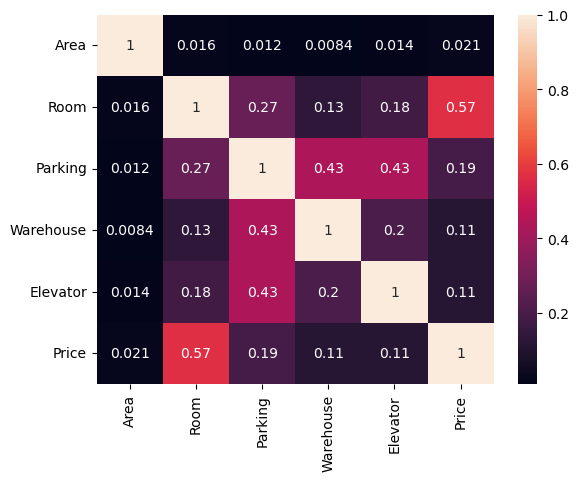

In [19]:
#Heatmap
sns.heatmap(df.corr(), annot=True)

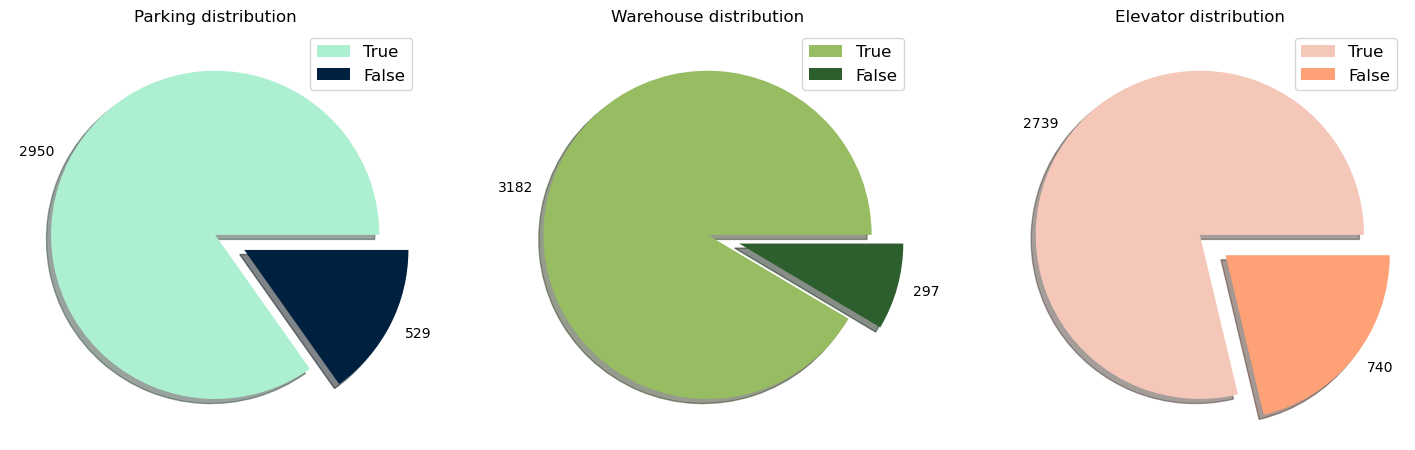

In [20]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6))

colors = [['#ADEFD1FF', '#00203FFF'], ['#97BC62FF', '#2C5F2D'], ['#F5C7B8FF', '#FFA177FF']]
explode = [0, 0.2]
columns = ['Parking', 'Warehouse', 'Elevator']
for i in range(3):
        data = df[columns[i]].value_counts()
        ax[i].pie(data, labels=data.values, explode=explode, colors=colors[i], shadow=True)
        ax[i].legend(labels=data.index, fontsize='large')
        ax[i].set_title('{} distribution'.format(columns[i]))

In [21]:
# number of houses in each region
df_n = df['Address'].value_counts().copy()

In [22]:
df_n = df_n[:8]

Text(0.5, 1.0, 'Number of flats in location')

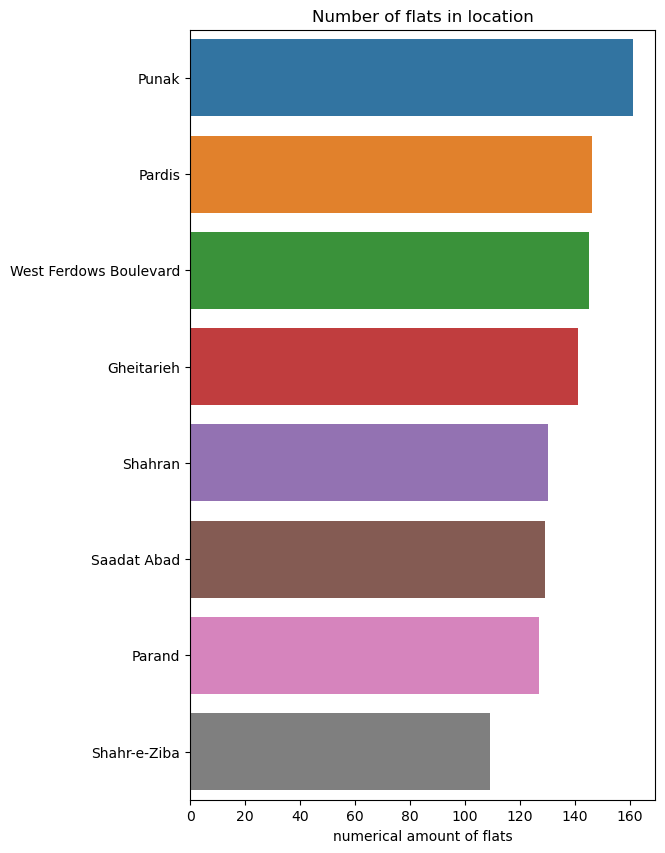

In [23]:
fig, ax = plt.subplots(figsize=(6,10))
sns.barplot(x=df_n.values, y=df_n.index,ax=ax)
plt.xlabel('numerical amount of flats')
plt.title('Number of flats in location')

In [24]:
# House price based on address
df.sort_values('Price',ascending=False)[['Address']].head(5)

,Address
1707,Zaferanieh
1810,Abazar
430,Lavasan
819,Ekhtiarieh
1332,Niavaran


In [25]:
df.sort_values('Price',ascending=True)[['Address']].head(5)

,Address
136,Qarchak
2770,Ozgol
731,Pardis
2721,Parand
2201,Andisheh


## Preprocessing

In [26]:
#change boolian dtypes
boolean_features = ['Parking','Warehouse','Elevator']
df[boolean_features] = df[boolean_features].astype('int64')

df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,63,1,1,1,1,Shahran,1.850000e+09
1,60,1,1,1,1,Shahran,1.850000e+09
2,79,2,1,1,1,Pardis,5.500000e+08
3,95,2,1,1,1,Shahrake Qods,9.025000e+08
4,123,2,1,1,1,Shahrake Gharb,7.000000e+09


In [27]:
df.shape

(3479, 7)

In [28]:
df.isnull().sum()

Area          0
Room          0
Parking       0
Warehouse     0
Elevator      0
Address      23
Price         0
dtype: int64

### Missing values

In [37]:
df.dropna(inplace=True)

## Outlier detection

In [29]:
print(f"Skewness of features:\n{df.skew()}")

Skewness of features:
Area         43.973452
Room          0.626076
Parking      -1.938846
Warehouse    -2.968963
Elevator     -1.404715
Price         4.779074
dtype: float64


<Axes: xlabel='Price'>

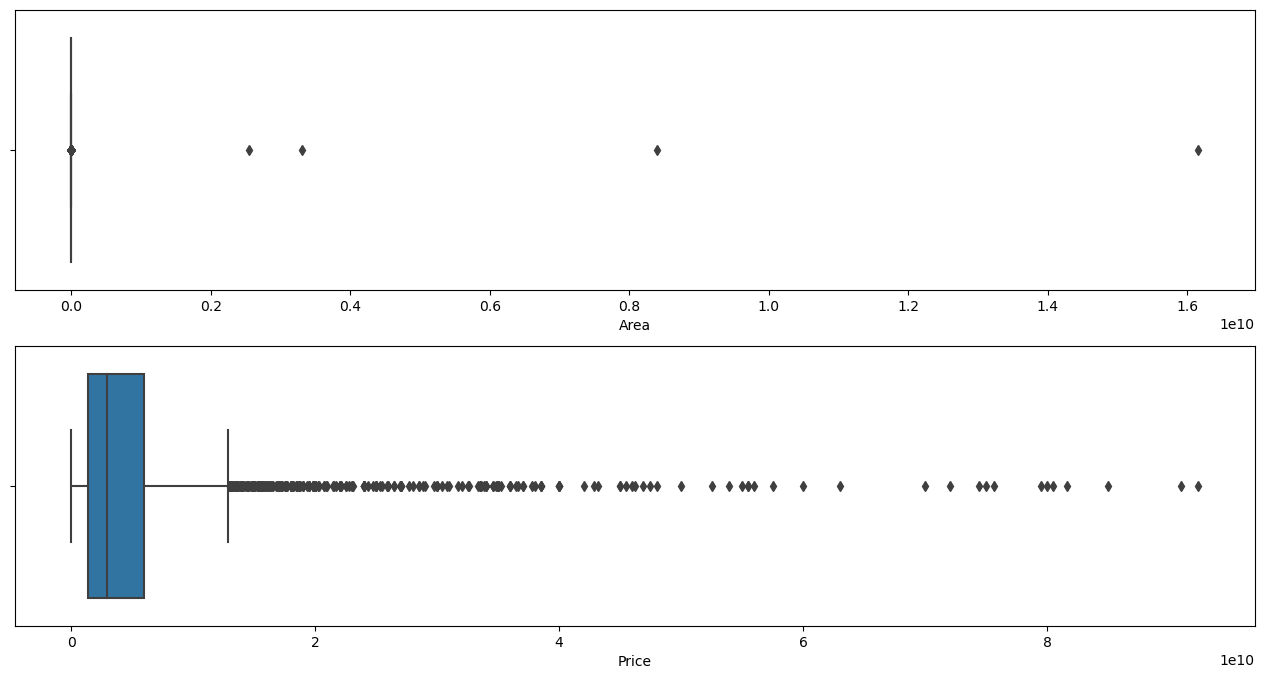

In [30]:
plt.figure(figsize = (16,8))

plt.subplot(2,1,1)
sns.boxplot(x = df['Area'])

plt.subplot(2,1,2)
sns.boxplot(x = df['Price'])

In [31]:
def lower_upper(x):
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    return lower, upper

lower_area, upper_area = lower_upper(df['Area'])
lower_price, upper_price = lower_upper(df['Price'])

print(f"Lower limit for area: {lower_area:0.2f}")
print(f"Upper limit for area: {upper_area:0.2f}")
print(f"Lower limit for price: {lower_price:,}")
print(f"Upper limit for price: {upper_price:,}")

Lower limit for area: -7.50
Upper limit for area: 196.50
Lower limit for price: -5,454,375,000.0
Upper limit for price: 12,872,625,000.0


In [32]:
area_outliers = np.where(df['Area'] > upper_area)
price_outliers = np.where(df['Price'] > upper_price)
# Return the unique, sorted array of values that are in either of the two input arrays.
total_outliers = np.union1d(area_outliers, price_outliers)

print(f"Number of area outliers: {len(df.iloc[area_outliers])}")
print(f"Number of price outliers: {len(df.iloc[price_outliers])}")
print(f"Number of outliers: {len(df.iloc[total_outliers])}")

Number of area outliers: 244
Number of price outliers: 310
Number of outliers: 367


In [33]:
df.shape

(3479, 7)

In [34]:
df = df.copy()
df.drop(total_outliers, inplace = True)
df.reset_index(drop = True, inplace = True)
print(f"Shape of new dataset: {df.shape}")

Shape of new dataset: (3112, 7)


In [35]:
print(f"Skewness of features after drop outliers:\n{df.skew()}")

Skewness of features after drop outliers:
Area         0.673961
Room         0.163452
Parking     -1.804289
Warehouse   -2.894954
Elevator    -1.392961
Price        1.290970
dtype: float64


## Encoding Address column

In [38]:
address_dummy = pd.get_dummies(df['Address'])
df_final = df.merge(address_dummy, left_index = True, right_index = True)
df_final.drop(columns = 'Address', inplace = True)
df_final.head(3)

,Area,Room,Parking,Warehouse,Elevator,Price,Abazar,Abbasabad,Abuzar,Afsarieh,...,Waterfall,West Ferdows Boulevard,West Pars,Yaftabad,Yakhchiabad,Yousef Abad,Zafar,Zaferanieh,Zargandeh,Zibadasht
0,63,1,1,1,1,1.850000e+09,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,60,1,1,1,1,1.850000e+09,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,79,2,1,1,1,5.500000e+08,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
df_final.shape

(3089, 193)

# Building Model

## Train Test Split

In [40]:
X = df_final.drop(columns = 'Price')
y = df_final['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## PolynomialFeatures

In [41]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()
poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

In [74]:
joblib.dump(X_train_poly,'poly.joblib')

['poly.joblib']

In [42]:
X_train_poly.shape

(2471, 18721)

## Hyper parameter tuning

In [43]:
def parameter_finder (model, parameters):
    
    start = time.time()
    
    grid = GridSearchCV(model, 
                        param_grid = parameters, 
                        refit = True, 
                        cv = KFold(shuffle = True, random_state = 1), 
                        n_jobs = -1)
    grid_fit = grid.fit(X_train_poly, y_train)
    y_train_pred = grid_fit.predict(X_train_poly)
    y_pred = grid_fit.predict(X_test_poly)
    
    train_score =grid_fit.score(X_train_poly, y_train)
    test_score = grid_fit.score(X_test_poly, y_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    
    model_name = str(model).split('(')[0]
    
    end = time.time()
    
    print(f"The best parameters for {model_name} model is: {grid_fit.best_params_}")
    print("--" * 10)
    print(f"(R2 score) in the training set is {train_score:0.2%} for {model_name} model.")
    print(f"(R2 score) in the testing set is {test_score:0.2%} for {model_name} model.")
    print(f"RMSE is {RMSE:,} for {model_name} model.")
    print("--" * 10)
    print(f"Runtime of the program is: {end - start:0.2f}")
    
       
    return train_score, test_score, RMSE

## Ridge

In [44]:
ridge = Ridge(random_state = 1) # Linear least squares with l2 regularization.
param_ridge = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

ridge_train_score, ridge_test_score, ridge_RMSE = parameter_finder(ridge, param_ridge)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The best parameters for Ridge model is: {'alpha': 10}
--------------------
(R2 score) in the training set is 90.97% for Ridge model.
(R2 score) in the testing set is 89.52% for Ridge model.
RMSE is 893,851,011.7953883 for Ridge model.
--------------------
Runtime of the program is: 42.89


## Lasso 

In [45]:
lasso = Lasso(random_state = 1) # Linear Model trained with L1 prior as regularizer.
param_lasso = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_train_score, lasso_test_score, lasso_RMSE = parameter_finder(lasso, param_lasso)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.470e+20, tolerance: 1.606e+18
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.726e+20, tolerance: 1.654e+18
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.150e+20, tolerance: 1.604e

The best parameters for Lasso model is: {'alpha': 10}
--------------------
(R2 score) in the training set is 92.90% for Lasso model.
(R2 score) in the testing set is 86.18% for Lasso model.
RMSE is 1,026,290,348.2953409 for Lasso model.
--------------------
Runtime of the program is: 47.53


## ElasticNet

In [46]:
eln = ElasticNet(random_state = 1) # Linear regression with combined L1 and L2 priors as regularizer.
param_eln = {'alpha': [0.001, 0.01, 0.1, 1, 10],
            'l1_ratio': [0.3, 0.4, 0.5, 0.6, 0.7]}

eln_train_score, eln_test_score, eln_RMSE = parameter_finder(eln, param_eln)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.286e+20, tolerance: 1.604e+18
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.684e+20, tolerance: 1.606e+18
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.585e+20, tolerance: 1.599e

The best parameters for ElasticNet model is: {'alpha': 0.01, 'l1_ratio': 0.7}
--------------------
(R2 score) in the training set is 91.15% for ElasticNet model.
(R2 score) in the testing set is 89.28% for ElasticNet model.
RMSE is 903,977,363.529168 for ElasticNet model.
--------------------
Runtime of the program is: 864.31


## RandomForestRegressor

In [47]:
rfr = RandomForestRegressor(random_state = 1, n_jobs = -1)
param_rfr = {'min_samples_split': [2, 3, 4, 5],
            'min_samples_leaf': [1, 2, 3]}

rfr_train_score, rfr_test_score, rfr_RMSE = parameter_finder(rfr, param_rfr)

The best parameters for RandomForestRegressor model is: {'min_samples_leaf': 1, 'min_samples_split': 5}
--------------------
(R2 score) in the training set is 95.42% for RandomForestRegressor model.
(R2 score) in the testing set is 81.25% for RandomForestRegressor model.
RMSE is 1,195,689,959.513397 for RandomForestRegressor model.
--------------------
Runtime of the program is: 1452.00


## DecisionTreeRegresso

In [48]:
dtr = DecisionTreeRegressor(random_state = 1)
param_dtr = {'min_samples_split': [2, 3, 4, 5],
            'min_samples_leaf': [1, 2, 3]}

dtr_train_score, dtr_test_score, dtr_RMSE = parameter_finder(dtr, param_dtr)

The best parameters for DecisionTreeRegressor model is: {'min_samples_leaf': 1, 'min_samples_split': 5}
--------------------
(R2 score) in the training set is 97.36% for DecisionTreeRegressor model.
(R2 score) in the testing set is 77.12% for DecisionTreeRegressor model.
RMSE is 1,320,583,539.4298537 for DecisionTreeRegressor model.
--------------------
Runtime of the program is: 32.76


## KNeighborsRegressor

In [49]:
knr = KNeighborsRegressor(n_jobs = -1)
param_knr = {'n_neighbors': [5, 10, 15, 20],
            'weights': ['uniform', 'distance']}

knr_train_score, knr_test_score, knr_RMSE = parameter_finder(knr, param_knr)

The best parameters for KNeighborsRegressor model is: {'n_neighbors': 10, 'weights': 'distance'}
--------------------
(R2 score) in the training set is 98.41% for KNeighborsRegressor model.
(R2 score) in the testing set is 66.09% for KNeighborsRegressor model.
RMSE is 1,607,682,803.9732654 for KNeighborsRegressor model.
--------------------
Runtime of the program is: 40.04


## XGBRegressor

In [50]:
xgboost = XGBRegressor(n_jobs = -1)
param_xgboost = {'n_estimators': [100,300],
             'learning_rate': [0.1,0.05],
             'subsample': [0.75],
             'colsample_bytree': [1],
             'max_depth': [3,4,5],
             'gamma': [0]}

xgboost_train_score, xgboost_test_score, xgboost_RMSE = parameter_finder(xgboost, param_xgboost)

/opt/conda/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/conda/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/conda/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/conda/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from p

The best parameters for XGBRegressor model is: {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.75}
--------------------
(R2 score) in the training set is 93.62% for XGBRegressor model.
(R2 score) in the testing set is 86.12% for XGBRegressor model.
RMSE is 1,028,793,490.9631872 for XGBRegressor model.
--------------------
Runtime of the program is: 7673.36


## Results

In [51]:
models_score = pd.DataFrame({'Training score': [ridge_train_score, lasso_train_score, eln_train_score, dtr_train_score, rfr_train_score, knr_train_score,xgboost_train_score],
                             'Testing score': [ridge_test_score, lasso_test_score, eln_test_score, dtr_test_score, rfr_test_score, knr_test_score,xgboost_test_score],
                             'RMSE': [ridge_RMSE, lasso_RMSE, eln_RMSE, dtr_RMSE, rfr_RMSE, knr_RMSE,xgboost_RMSE]},
                             index = ['Ridge', 'Lasso','ElasticNet', 'DecisionTreeRegressor', 'RandomForestRegressor', 'KNeighborsRegressor','XGBoostRegressor'])

models_score

,Training score,Testing score,RMSE
Ridge,0.909734,0.895189,8.938510e+08
Lasso,0.928950,0.861829,1.026290e+09
ElasticNet,0.911503,0.892801,9.039774e+08
DecisionTreeRegressor,0.973585,0.771225,1.320584e+09
RandomForestRegressor,0.954190,0.812451,1.195690e+09
KNeighborsRegressor,0.984090,0.660939,1.607683e+09
XGBoostRegressor,0.936153,0.861154,1.028793e+09


## Results Visualization

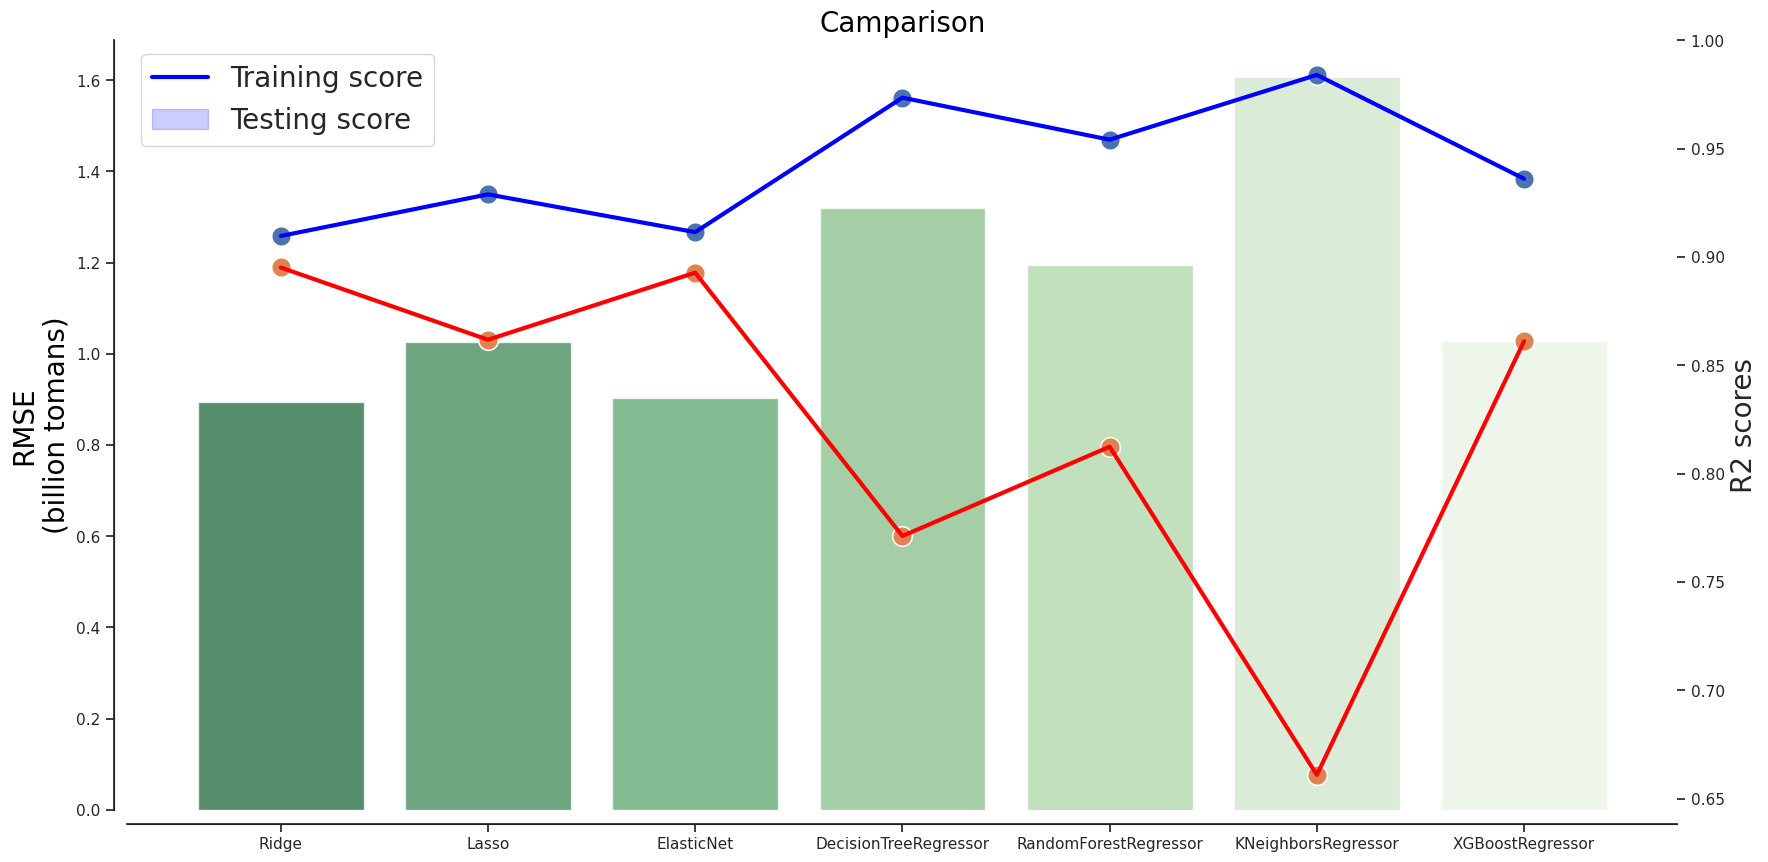

In [52]:
fig, ax = plt.subplots(figsize=(20,10))

sns.set(style='white')

ax.set_title("Camparison", fontsize = 20)

ax = sns.barplot(x = list(models_score.index), y = models_score['RMSE']/1000000000, alpha = 0.7, palette='Greens_r')

ax.set_ylabel("RMSE\n(billion tomans)", fontsize = 20)

sec_ax = ax.twinx()

sec_ax = sns.lineplot(x = list(models_score.index), y = models_score['Training score'], linewidth = 3, color = 'blue')
sec_ax = sns.scatterplot(x = list(models_score.index), y = models_score['Training score'], s = 200)

sec_ax = sns.lineplot(x = list(models_score.index), y = models_score['Testing score'], linewidth = 3, color = 'red')
sec_ax = sns.scatterplot(x = list(models_score.index), y = models_score['Testing score'], s = 200)

sec_ax.set_ylabel("R2 scores", fontsize = 20)

sec_ax.legend(labels = ['Training score', 'Testing score'], fontsize = 20)


sns.despine(offset = 10)

plt.show()

## Save Model

In [58]:
Rg = Ridge(random_state = 1, alpha=10)
res_ridge = Rg.fit(X_train_poly,y_train) 

In [67]:
joblib.dump(res_ridge,'ridge.joblib')

['ridge.joblib']

## Load Model

In [68]:
model = joblib.load('ridge.joblib')

In [71]:
y_pred = model.predict(X_test_poly)

In [72]:
from sklearn.metrics import r2_score

In [73]:
print(r2_score(y_test, y_pred))

0.8951888728935774
